In [1]:
pip install langchain langchain-openai sentence-transformers matplotlib numpy huggingface_hub openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.1.0
    Uninstalling langchain-core-1.1.0:
      Successfully uninstalled langchain-core-1.1.0


In [2]:
pip install langchain-openai

In [3]:
pip install sentence-transformers


In [4]:
pip install matplotlib

In [5]:
pip install numpy


In [6]:
pip install huggingface_hub

In [7]:
pip install openai

Loading models...
Models loaded.
Starting chain for: donut


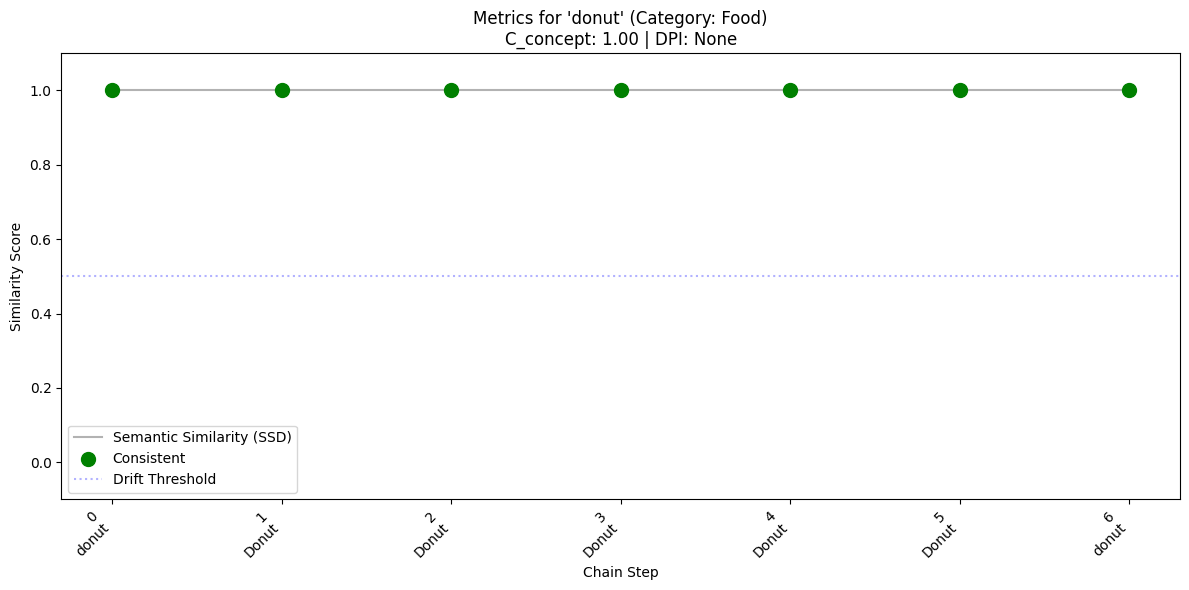

Finished donut. DPI: None, Consistency: 1.0
Starting chain for: otter


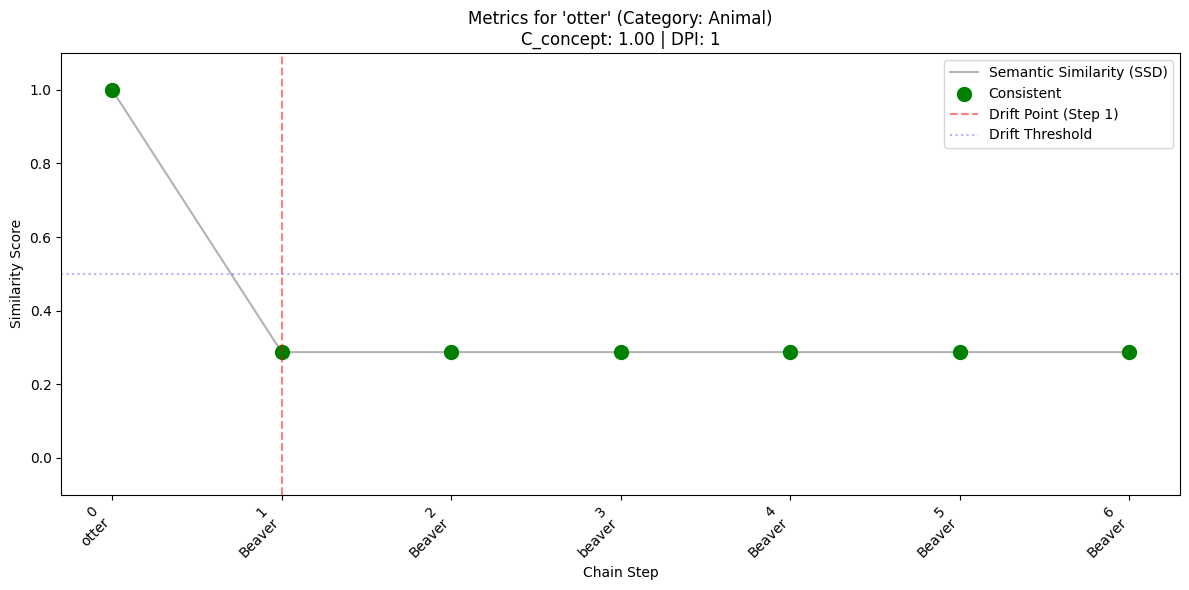

Finished otter. DPI: 1, Consistency: 1.0

Results saved to experiment_results.json


In [ ]:
# import os
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# from langchain_openai import ChatOpenAI
# from langchain_core.messages import HumanMessage
# from sentence_transformers import SentenceTransformer, util

# # ==========================================
# # 1. CONFIGURATION & SETUP
# # ==========================================

# # --- API KEY SETUP ---
# # REPLACE THIS with your actual Nebius API key
# os.environ["NEBIUS_API_KEY"] = "v1.CmQKHHN0YXRpY2tleS1lMDBncDBhYThtOTF4bnI3YmYSIXNlcnZpY2VhY2NvdW50LWUwMHh0dnBxZTZ4Y3I0bnk3NjIMCMuYtckGENKzjvsBOgwIy5vNlAcQwMWB6AJAAloDZTAw.AAAAAAAAAAF3-m3KEb-kNhNMSEYKc-x1nUMrz8p95iA8DgKwWHvnDQNfNEaiJtvIjfXQtUvU6qaYci0Vk_stRmKvxwzTcfMI"

# # --- MODEL CONFIGURATION ---
# MODEL_CONFIG = {
#     "weak":   "meta-llama/Meta-Llama-3.1-8B-Instruct",
#     "avg":    "google/gemma-2-9b-it-fast",
#     "strong": "openai/gpt-oss-20b"
# }

# # --- INITIALIZATION ---
# def build_model(model_name):
#     return ChatOpenAI(
#         base_url="https://api.studio.nebius.ai/v1",
#         api_key=os.environ["NEBIUS_API_KEY"],
#         model=model_name,
#         temperature=0.7
#     )

# # Initialize models and embedding tool
# print("Loading models...")
# models = {role: build_model(name) for role, name in MODEL_CONFIG.items()}
# embedder = SentenceTransformer("all-MiniLM-L6-v2")
# model_order = ["weak", "avg", "strong"]
# print("Models loaded.")

# # ==========================================
# # 2. CORE GAME LOGIC (Telephone)
# # ==========================================

# def one_chain_block(model, chain, chain_desc):
#     description = chain_desc[-1]

#     # 1. Guess the word based on description
#     guess = model.invoke([
#         HumanMessage(
#             f"You recieved this description: \"{description}\".\n"
#             f"Guess the word. Reply with ONLY the guessed word."
#         )
#     ]).content.strip()

#     # Clean up punctuation from guess (optional but recommended)
#     guess = guess.strip(".\"")
#     chain.append(guess)

#     # 2. Create NEW description based on the guessed word
#     new_description = model.invoke([
#         HumanMessage(
#             f"You just heard this description: \"{description}\".\n"
#             f"You guessed the word: \"{guess}\".\n"
#             f"Create another description for your guessed word in ONLY 2 sentences."
#             f"WITHOUT naming it directly."
#         )
#     ]).content
#     chain_desc.append(new_description)

#     return chain, chain_desc

# def run_over_one_word(word, steps=1):
#     chain = [word]
#     chain_desc = []
#     chain_models = ["avg"] # Tracks which model produced which word

#     # Initial description by 'avg' model
#     print(f"Starting chain for: {word}")
#     description = models["avg"].invoke([
#         HumanMessage(f"Describe this word in 3 sentences without naming it: {word}.")
#     ]).content
#     chain_desc.append(description)

#     # Run the loop
#     for i in range(steps):
#         for role in model_order:
#             model = models[role]
#             chain, chain_desc = one_chain_block(model, chain, chain_desc)
#             chain_models.append(role)

#     return chain, chain_desc, chain_models

#     # ==========================================
# # 3. METRICS IMPLEMENTATION
# # ==========================================

# def calculate_ssd(chain):
#     """
#     Metric 1: Semantic Similarity Decay (SSD)
#     Cosine similarity between W0 and Wt.
#     """
#     orig_emb = embedder.encode(chain[0], convert_to_tensor=True)
#     sims = []

#     for w in chain:
#         w_emb = embedder.encode(w, convert_to_tensor=True)
#         sim = util.cos_sim(orig_emb, w_emb).item()
#         sims.append(sim)
#     return sims

# def calculate_dpi(ssd_values, threshold=0.5):
#     """
#     Metric 3: Drift Point Index (DPI)
#     First step t where SSD < 0.5.
#     """
#     for t, score in enumerate(ssd_values):
#         if score < threshold:
#             return t
#     return None

# def calculate_conceptual_consistency(judge_model, chain):
#     """
#     Metric 4: Conceptual Consistency
#     Uses LLM Judge to check if W_t is same category as W_0.
#     """
#     w0 = chain[0]

#     # 1. Identify Category of W0
#     cat_prompt = f"What is the single broad category for the word '{w0}'? (e.g., Fruit, Animal, Job, Place). Reply with ONE word."
#     category = judge_model.invoke([HumanMessage(cat_prompt)]).content.strip()

#     consistency_mask = []

#     # 2. Check W_t against that category
#     for word in chain:
#         check_prompt = (
#             f"Is '{word}' a type of {category}? "
#             f"Reply 'YES' if it is semantically close or the same category, 'NO' if it is completely different."
#         )
#         response = judge_model.invoke([HumanMessage(check_prompt)]).content.strip().upper()

#         is_consistent = 1 if "YES" in response else 0
#         consistency_mask.append(is_consistent)

#     # Calculate Score
#     c_concept = sum(consistency_mask) / len(consistency_mask)

#     return consistency_mask, c_concept, category

#     # ==========================================
# # 4. VISUALIZATION
# # ==========================================

# def plot_metrics_and_save(word, chain, chain_desc, chain_models):
#     # --- Calculate Metrics ---
#     w_ssd = calculate_ssd(chain)
#     dpi = calculate_dpi(w_ssd, threshold=0.5)

#     # Use 'strong' model as the judge for consistency
#     const_mask, c_concept, cat_name = calculate_conceptual_consistency(models['strong'], chain)

#     # --- Plotting ---
#     steps = np.arange(len(w_ssd))
#     plt.figure(figsize=(12, 6))

#     # 1. SSD Line
#     plt.plot(steps, w_ssd, linestyle='-', color='gray', alpha=0.6, label='Semantic Similarity (SSD)', zorder=1)

#     # 2. Consistency Markers (Green=Yes, Red=No)
#     for i, (score, is_const) in enumerate(zip(w_ssd, const_mask)):
#         color = 'green' if is_const else 'red'
#         marker = 'o' if is_const else 'X'
#         label = "Consistent" if (is_const and i==0) else ("Inconsistent" if (not is_const and i==0) else "")
#         plt.scatter(i, score, color=color, s=100, marker=marker, zorder=2, label=label)

#     # 3. DPI Line
#     if dpi is not None:
#         plt.axvline(x=dpi, color='red', linestyle='--', alpha=0.5, label=f'Drift Point (Step {dpi})')

#     plt.axhline(0.5, color='blue', linestyle=':', alpha=0.3, label='Drift Threshold')

#     plt.title(f"Metrics for '{word}' (Category: {cat_name})\nC_concept: {c_concept:.2f} | DPI: {dpi}")
#     plt.xlabel("Chain Step")
#     plt.ylabel("Similarity Score")
#     plt.ylim(-0.1, 1.1)

#     # X-axis labels showing the word at that step
#     step_labels = [f"{i}\n{w}" for i, w in enumerate(chain)]
#     plt.xticks(steps, step_labels, rotation=45, ha='right')

#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     # --- Return Data for JSON ---
#     return {
#         "word": word,
#         "chain": chain,
#         "ssd": w_ssd,
#         "dpi": dpi,
#         "c_concept_score": c_concept,
#         "consistency_mask": const_mask,
#         "category": cat_name
#     }

# # ==========================================
# # 5. MAIN EXECUTION LOOP
# # ==========================================

# if __name__ == "__main__":
#     # specific word lists
#     test_words = ['donut', 'otter']

#     all_results = []

#     for word in test_words:
#         # 1. Run Game
#         chain, chain_desc, chain_models = run_over_one_word(word, steps=2)

#         # 2. Plot & Calculate
#         stats = plot_metrics_and_save(word, chain, chain_desc, chain_models)
#         all_results.append(stats)

#         print(f"Finished {word}. DPI: {stats['dpi']}, Consistency: {stats['c_concept_score']}")

#     # 3. Save to JSON
#     with open("experiment_results.json", "w") as f:
#         json.dump(all_results, f, indent=4)
#     print("\nResults saved to experiment_results.json")







Loading models...
Models loaded.

STARTING GAME FOR: MARIANA TRENCH

[INITIAL DESCRIPTION (Input for Player 1)]
"It is the deepest known part of the world's oceans.  Extreme pressure and near-freezing temperatures define its environment.  Only a handful of humans have ever ventured to its depths. 


"

--- Step 1 (Player: weak) ---
GUESS: The Mariana Trench
NEW DESCRIPTION (Input for next player):
"Located in the western Pacific Ocean, this natural wonder is a staggering 36,000 feet deep, a chasm that plunges into the darkness. Its lowest point, known as the "Challenger Deep", is a nearly inaccessible region of unrelenting pressure and cold that has captivated the imagination of scientists and explorers for centuries."

--- Step 2 (Player: avg) ---
GUESS: Mariana Trench
NEW DESCRIPTION (Input for next player):
"This underwater canyon stretches for over 1,500 miles, a scar on the face of the Earth's crust.  Its crushing depths, home to bizarre and resilient lifeforms, remain one of the 

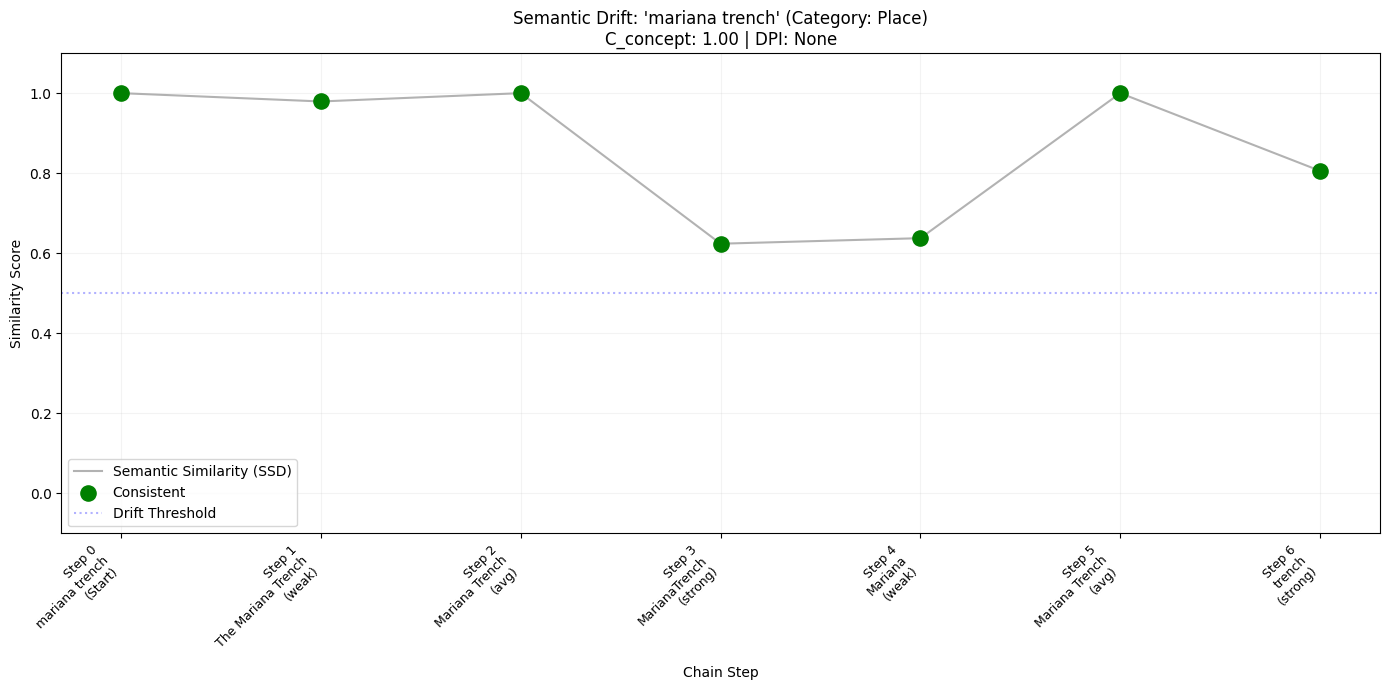

  > Finished. Drift Point: None, Consistency Score: 1.0

STARTING GAME FOR: MOUNT EVEREST

[INITIAL DESCRIPTION (Input for Player 1)]
"It's the highest point on Earth, towering over the world like a giant. 

Scaling its treacherous slopes is a feat of human endurance and skill, attracting adventurers from across the globe. 

Its name evokes a sense of awe and respect, a reminder of the immense power of nature.  



"

--- Step 1 (Player: weak) ---
GUESS: Mount Everest
NEW DESCRIPTION (Input for next player):
"This iconic mountain is often referred to as a "Savage Beauty", its breathtaking peaks and glaciers a testament to the raw power of the Earth's geological forces. For centuries, climbers have attempted to conquer its lofty summit, driven by a sense of adventure and a desire to push human limits."

--- Step 2 (Player: avg) ---
GUESS: Matterhorn
NEW DESCRIPTION (Input for next player):
"Its symmetrical, pyramid-shaped summit pierces the sky, a jagged crown against the backdrop of pr

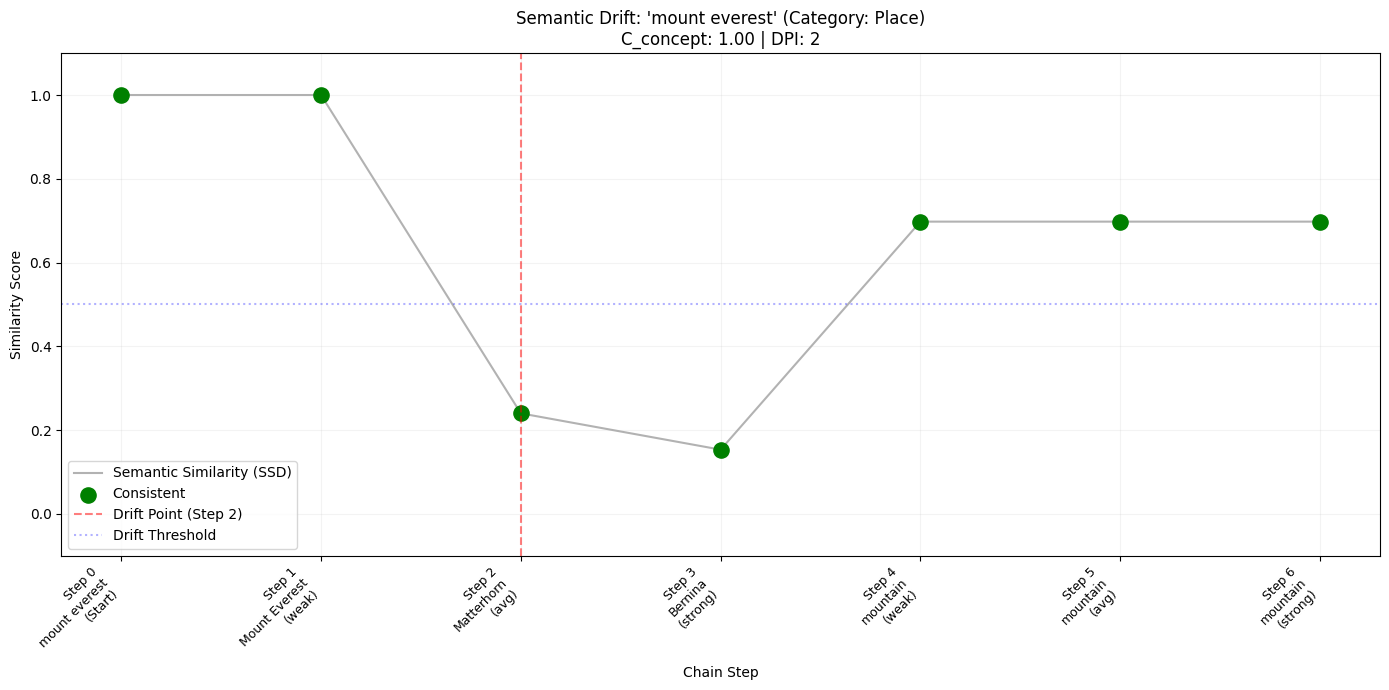

  > Finished. Drift Point: 2, Consistency Score: 1.0

Results saved to experiment_results.json


In [ ]:
# import os
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# from langchain_openai import ChatOpenAI
# from langchain_core.messages import HumanMessage
# from sentence_transformers import SentenceTransformer, util

# # ==========================================
# # 1. CONFIGURATION & SETUP
# # ==========================================

# # --- API KEY SETUP ---
# # REPLACE THIS with your actual Nebius API key
# os.environ["NEBIUS_API_KEY"] = "v1.CmQKHHN0YXRpY2tleS1lMDBncDBhYThtOTF4bnI3YmYSIXNlcnZpY2VhY2NvdW50LWUwMHh0dnBxZTZ4Y3I0bnk3NjIMCMuYtckGENKzjvsBOgwIy5vNlAcQwMWB6AJAAloDZTAw.AAAAAAAAAAF3-m3KEb-kNhNMSEYKc-x1nUMrz8p95iA8DgKwWHvnDQNfNEaiJtvIjfXQtUvU6qaYci0Vk_stRmKvxwzTcfMI"

# # --- MODEL CONFIGURATION ---
# MODEL_CONFIG = {
#     "weak":   "meta-llama/Meta-Llama-3.1-8B-Instruct",
#     "avg":    "google/gemma-2-9b-it-fast",
#     "strong": "openai/gpt-oss-20b"
# }

# # --- INITIALIZATION ---
# def build_model(model_name):
#     return ChatOpenAI(
#         base_url="https://api.studio.nebius.ai/v1",
#         api_key=os.environ["NEBIUS_API_KEY"],
#         model=model_name,
#         temperature=0.7
#     )

# print("Loading models...")
# models = {role: build_model(name) for role, name in MODEL_CONFIG.items()}
# embedder = SentenceTransformer("all-MiniLM-L6-v2")
# GAME_PLAYER_ORDER = ["weak", "avg", "strong"]
# print("Models loaded.")

# # ==========================================
# # 2. CORE GAME LOGIC (Telephone)
# # ==========================================

# def one_chain_block(model, chain, chain_desc):
#     """
#     A single turn in the game.
#     1. Model receives description -> Guesses word.
#     2. Model receives own guess -> Writes new description.
#     """
#     previous_description = chain_desc[-1]

#     # --- Step 1: Guess the word ---
#     guess_response = model.invoke([
#         HumanMessage(
#             f"You recieved this description: \"{previous_description}\".\n"
#             f"Guess the word. Reply with ONLY the guessed word, no punctuation."
#         )
#     ])
#     guess = guess_response.content.strip().strip(".\"")
#     chain.append(guess)

#     # --- Step 2: Describe the guess ---
#     description_response = model.invoke([
#         HumanMessage(
#             f"You just heard this description: \"{previous_description}\".\n"
#             f"You guessed the word: \"{guess}\".\n"
#             f"Create another description for your guessed word in ONLY 2 sentences."
#             f"WITHOUT naming it directly."
#         )
#     ])
#     new_description = description_response.content.strip()
#     chain_desc.append(new_description)

#     return chain, chain_desc

# def run_over_one_word(word, steps=1):
#     """
#     Runs the telephone game with verbose printing.
#     """
#     chain = [word]
#     chain_desc = []
#     chain_models = ["Start"]

#     # --- Initial Setup ---
#     print(f"\n{'='*60}")
#     print(f"STARTING GAME FOR: {word.upper()}")
#     print(f"{'='*60}")

#     # 1. Initial description by 'avg' model
#     initial_desc = models["avg"].invoke([
#         HumanMessage(f"Describe this word in 3 sentences without naming it: {word}.")
#     ]).content
#     chain_desc.append(initial_desc)

#     print(f"\n[INITIAL DESCRIPTION (Input for Player 1)]")
#     print(f"\"{initial_desc}\"")

#     # --- The Game Loop ---
#     global_step_count = 0

#     for i in range(steps):
#         for role in GAME_PLAYER_ORDER:
#             global_step_count += 1
#             print(f"\n--- Step {global_step_count} (Player: {role}) ---")

#             current_player_model = models[role]

#             # Run the turn
#             chain, chain_desc = one_chain_block(current_player_model, chain, chain_desc)
#             chain_models.append(role)

#             # --- PRINTING THE RESULTS ---
#             current_guess = chain[-1]
#             current_description_generated = chain_desc[-1]

#             print(f"GUESS: {current_guess}")
#             print(f"NEW DESCRIPTION (Input for next player):")
#             print(f"\"{current_description_generated}\"")

#     return chain, chain_desc, chain_models

# # ==========================================
# # 3. METRICS & JUDGE IMPLEMENTATION
# # ==========================================

# def calculate_ssd(chain):
#     orig_emb = embedder.encode(chain[0], convert_to_tensor=True)
#     sims = []
#     for w in chain:
#         w_emb = embedder.encode(w, convert_to_tensor=True)
#         sim = util.cos_sim(orig_emb, w_emb).item()
#         sims.append(sim)
#     return sims

# def calculate_dpi(ssd_values, threshold=0.5):
#     for t, score in enumerate(ssd_values):
#         if score < threshold:
#             return t
#     return None

# def calculate_conceptual_consistency(judge_model, chain):
#     w0 = chain[0]

#     # 1. Judge defines the category
#     cat_prompt = f"What is the single broad category for the word '{w0}'? (e.g., Fruit, Animal, Job, Place). Reply with ONE word."
#     category = judge_model.invoke([HumanMessage(cat_prompt)]).content.strip()

#     consistency_mask = []

#     # 2. Judge verifies every word in the chain
#     for word in chain:
#         check_prompt = (
#             f"Is '{word}' a type of {category}? "
#             f"Reply 'YES' if it is semantically close or the same category, 'NO' if it is completely different."
#         )
#         response = judge_model.invoke([HumanMessage(check_prompt)]).content.strip().upper()

#         is_consistent = 1 if "YES" in response else 0
#         consistency_mask.append(is_consistent)

#     c_concept = sum(consistency_mask) / len(consistency_mask)
#     return consistency_mask, c_concept, category

# # ==========================================
# # 4. VISUALIZATION
# # ==========================================

# def plot_metrics_and_save(word, chain, chain_desc, chain_models):
#     # --- Calculate Metrics ---
#     w_ssd = calculate_ssd(chain)
#     dpi = calculate_dpi(w_ssd, threshold=0.5)

#     # Strong model acts as JUDGE
#     judge = models['strong']
#     const_mask, c_concept, cat_name = calculate_conceptual_consistency(judge, chain)

#     # --- Plotting ---
#     steps = np.arange(len(w_ssd))
#     plt.figure(figsize=(14, 7))

#     # SSD Line
#     plt.plot(steps, w_ssd, linestyle='-', color='gray', alpha=0.6, label='Semantic Similarity (SSD)', zorder=1)

#     # Consistency Markers
#     for i, (score, is_const) in enumerate(zip(w_ssd, const_mask)):
#         color = 'green' if is_const else 'red'
#         marker = 'o' if is_const else 'X'
#         label = "Consistent" if (is_const and i==0) else ("Inconsistent" if (not is_const and i==0) else "")
#         plt.scatter(i, score, color=color, s=120, marker=marker, zorder=2, label=label)

#     # DPI Line
#     if dpi is not None:
#         plt.axvline(x=dpi, color='red', linestyle='--', alpha=0.5, label=f'Drift Point (Step {dpi})')

#     plt.axhline(0.5, color='blue', linestyle=':', alpha=0.3, label='Drift Threshold')

#     plt.title(f"Semantic Drift: '{word}' (Category: {cat_name})\nC_concept: {c_concept:.2f} | DPI: {dpi}")
#     plt.xlabel("Chain Step")
#     plt.ylabel("Similarity Score")
#     plt.ylim(-0.1, 1.1)

#     # Label x-axis with Word + Model
#     x_labels = []
#     for i, w in enumerate(chain):
#         # Safety check for index
#         model_name = chain_models[i] if i < len(chain_models) else "?"
#         x_labels.append(f"Step {i}\n{w}\n({model_name})")

#     plt.xticks(steps, x_labels, rotation=45, ha='right', fontsize=9)
#     plt.grid(True, alpha=0.15)
#     plt.legend(loc='lower left')

#     plt.tight_layout()
#     plt.show()

#     return {
#         "word": word,
#         "chain": chain,
#         "models": chain_models,
#         "ssd": w_ssd,
#         "dpi": dpi,
#         "c_concept": c_concept,
#         "category": cat_name
#     }

# # ==========================================
# # 5. MAIN EXECUTION LOOP
# # ==========================================

# if __name__ == "__main__":
#     test_words = ['mariana trench', 'mount everest']

#     all_results = []

#     for word in test_words:
#         # 1. Run Game (Weak -> Avg -> Strong)
#         # This will now print descriptions to the console
#         chain, chain_desc, chain_models = run_over_one_word(word, steps=2)

#         # 2. Evaluation
#         stats = plot_metrics_and_save(word, chain, chain_desc, chain_models)
#         all_results.append(stats)

#         print(f"  > Finished. Drift Point: {stats['dpi']}, Consistency Score: {stats['c_concept']}")

#     # 3. Save Results
#     with open("experiment_results.json", "w") as f:
#         json.dump(all_results, f, indent=4)
#     print("\nResults saved to experiment_results.json")

Loading models...
Models loaded.

STARTING GAME FOR: MARIANA TRENCH (Model: Weak Only)

[INITIAL DESCRIPTION]
"Located in the Pacific Ocean, this deep depression is the lowest point on Earth, with a depth of over 36,000 feet. Its extreme depth is due to the way the Earth's crust has been pushed down by the movement of tectonic plates, creating a massive chasm in the ocean floor. The pressure at this point is so great that no light can penetrate, making it one of the most inhospitable and mysterious environments on the planet."

--- Step 1 ---
UNDERSTOOD MEANING: "This passage describes the Mariana Trench, specifically the Challenger Deep, the lowest point on Earth."
EXPLICIT GUESS:     [Mariana]
NEW DESCRIPTION:    "Located in the Pacific Ocean, this underwater trench is the deepest point on our planet, with a staggering depth that plunges over 36,000 feet below the surface. The lowest part of the trench, known as the Challenger Deep, is a seemingly bottomless pit that holds the record

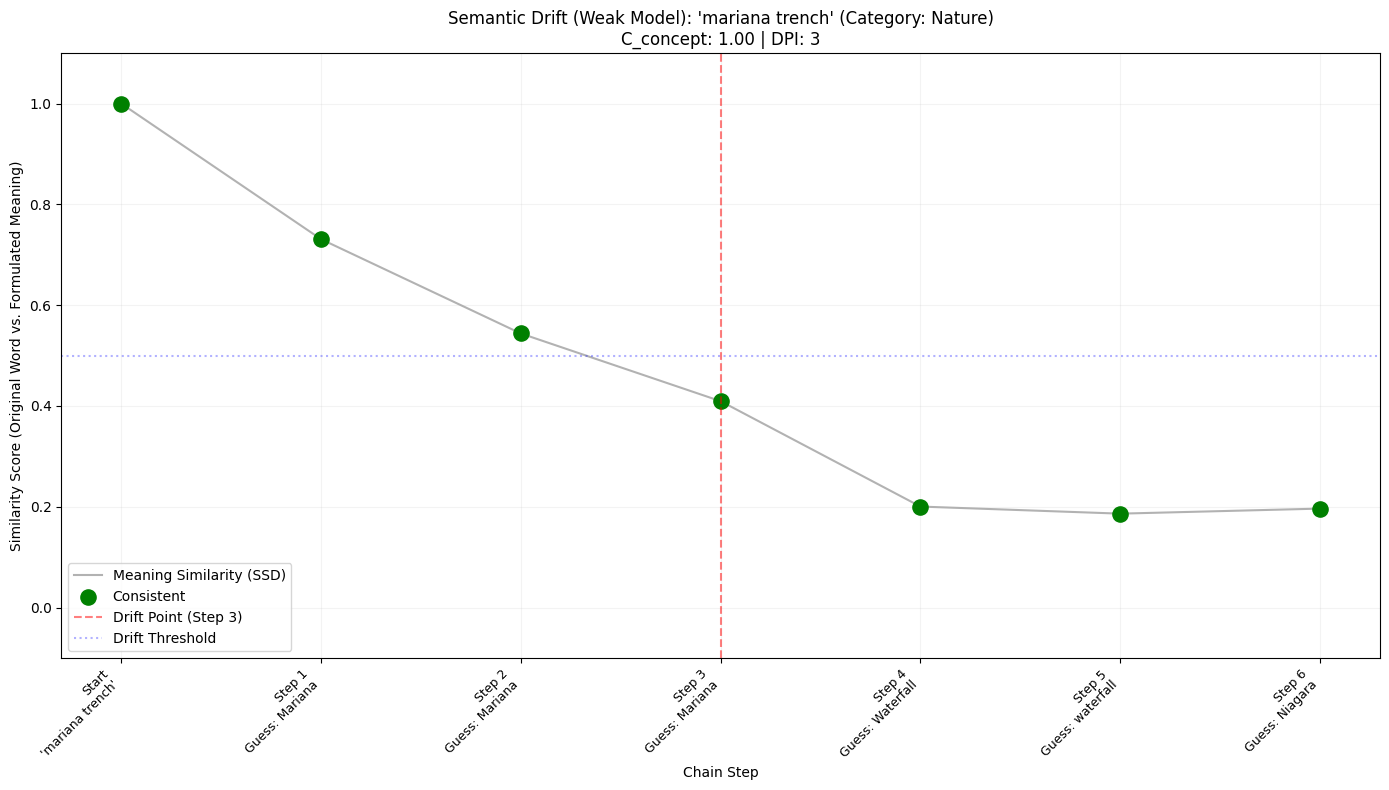

  > Finished. Drift Point: 3, Consistency Score: 1.0

STARTING GAME FOR: MOUNT EVEREST (Model: Weak Only)

[INITIAL DESCRIPTION]
"This majestic mountain is the highest point on Earth, towering over 8,000 meters above sea level and attracting adventurers and mountaineers from around the globe. Its snow-capped peak is a formidable challenge, requiring extensive climbing experience and specialized equipment to conquer. Located in the Himalayas, this iconic landmark has captivated the imagination of people for centuries, serving as a symbol of human achievement and the awe-inspiring power of nature."

--- Step 1 ---
UNDERSTOOD MEANING: "This description refers to Mount Everest, the ultimate symbol of human ambition and the sublime power of nature, embodying a formidable challenge that tests the limits of human endurance and achievement."
EXPLICIT GUESS:     [Everest]
NEW DESCRIPTION:    "This towering natural wonder stands as a sentinel to human ingenuity and the unyielding force of the na

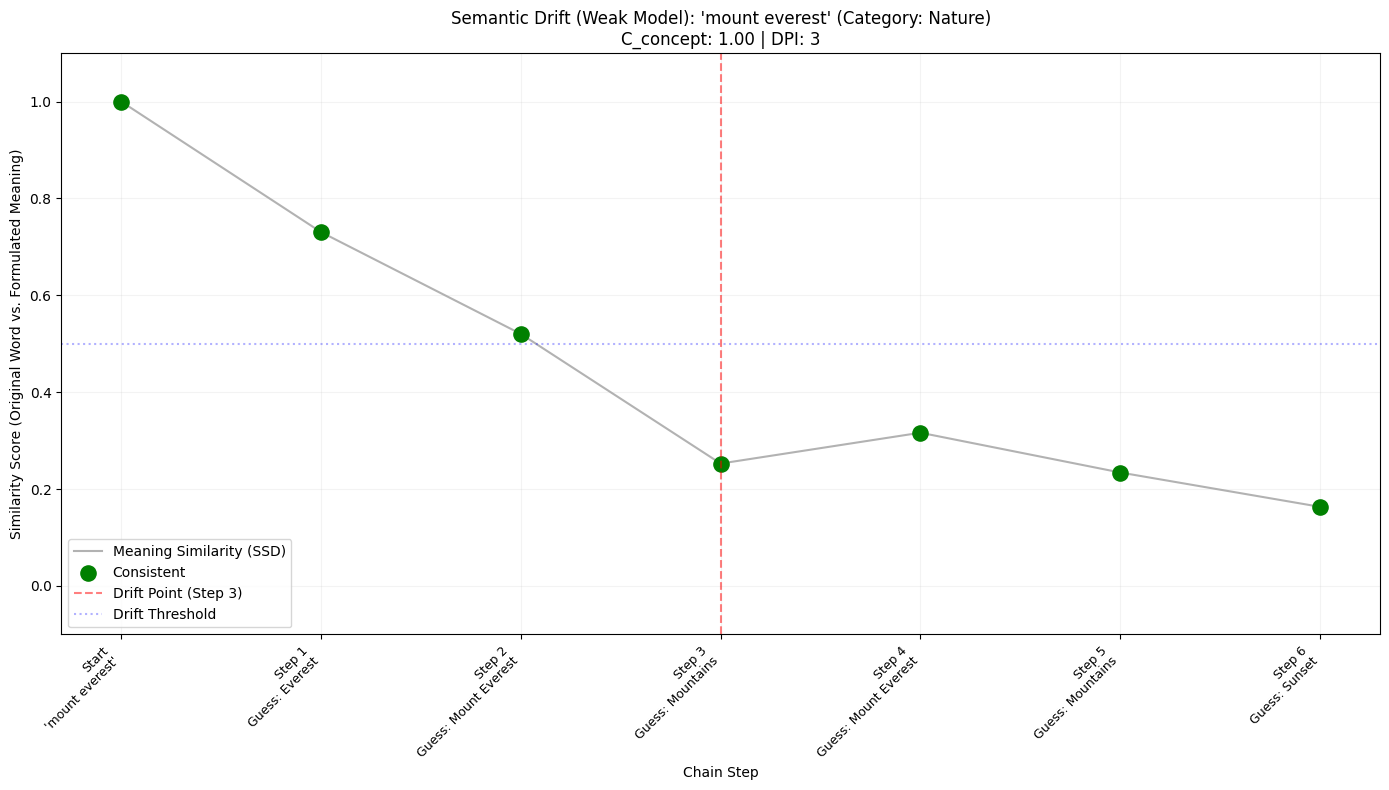

  > Finished. Drift Point: 3, Consistency Score: 1.0

Results saved to experiment_results_weak_guesses.json


In [ ]:
# import os
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# from langchain_openai import ChatOpenAI
# from langchain_core.messages import HumanMessage
# from sentence_transformers import SentenceTransformer, util

# # ==========================================
# # 1. CONFIGURATION & SETUP
# # ==========================================

# # --- API KEY SETUP ---
# # REPLACE THIS with your actual Nebius API key
# os.environ["NEBIUS_API_KEY"] = "v1.CmQKHHN0YXRpY2tleS1lMDBncDBhYThtOTF4bnI3YmYSIXNlcnZpY2VhY2NvdW50LWUwMHh0dnBxZTZ4Y3I0bnk3NjIMCMuYtckGENKzjvsBOgwIy5vNlAcQwMWB6AJAAloDZTAw.AAAAAAAAAAF3-m3KEb-kNhNMSEYKc-x1nUMrz8p95iA8DgKwWHvnDQNfNEaiJtvIjfXQtUvU6qaYci0Vk_stRmKvxwzTcfMI"

# # --- MODEL CONFIGURATION ---
# MODEL_CONFIG = {
#     "weak":   "meta-llama/Meta-Llama-3.1-8B-Instruct",
#     "avg":    "google/gemma-2-9b-it-fast",
#     "strong": "openai/gpt-oss-20b"
# }

# # --- INITIALIZATION ---
# def build_model(model_name):
#     return ChatOpenAI(
#         base_url="https://api.studio.nebius.ai/v1",
#         api_key=os.environ["NEBIUS_API_KEY"],
#         model=model_name,
#         temperature=0.7
#     )

# print("Loading models...")
# models = {role: build_model(name) for role, name in MODEL_CONFIG.items()}
# embedder = SentenceTransformer("all-MiniLM-L6-v2")
# print("Models loaded.")

# # ==========================================
# # 2. CORE GAME LOGIC (Telephone)
# # ==========================================

# def one_chain_block(model, chain_meanings, chain_desc, chain_guesses):
#     """
#     A single turn in the game using the Weak Model.
#     Now performs 3 actions:
#     1. Formulate Meaning (The Core Logic)
#     2. Write New Description (The Output)
#     3. Guess Word (The Side Task - for logging only)
#     """
#     previous_description = chain_desc[-1]

#     # --- Action A: Formulate Meaning (Main Logic) ---
#     # The model tries to summarize the core concept it understood.
#     meaning_response = model.invoke([
#         HumanMessage(
#             f"You received this description: \"{previous_description}\".\n"
#             f"In one short sentence or phrase, interpret what this describes. "
#             f"Do NOT just guess a word, explain the *meaning* or *concept* you understood."
#         )
#     ])
#     meaning = meaning_response.content.strip()
#     chain_meanings.append(meaning)

#     # --- Action B: Describe the Meaning (Main Logic) ---
#     # The model uses its own interpretation (meaning) to pass the message along.
#     description_response = model.invoke([
#         HumanMessage(
#             f"You interpret the concept as: \"{meaning}\".\n"
#             f"Now, describe this concept for the next person in ONLY 2 sentences."
#             f"Do NOT name the concept directly."
#         )
#     ])
#     new_description = description_response.content.strip()
#     chain_desc.append(new_description)

#     # --- Action C: Explicit Guess (Side Task) ---
#     # This is ISOLATED. It does not affect the next step.
#     guess_response = model.invoke([
#         HumanMessage(
#             f"You received this description: \"{previous_description}\".\n"
#             f"If you had to guess the specific single word being described, what would it be? "
#             f"Reply with ONLY the word, no punctuation."
#         )
#     ])
#     guess = guess_response.content.strip().strip(".\"")
#     chain_guesses.append(guess)

#     return chain_meanings, chain_desc, chain_guesses

# def run_over_one_word(word, steps=6):
#     """
#     Runs the telephone game using ONLY the WEAK model.
#     """
#     chain_meanings = [word]
#     chain_desc = []
#     chain_guesses = [] # New list to store the explicit guesses

#     player_model = models["weak"]

#     # --- Initial Setup ---
#     print(f"\n{'='*60}")
#     print(f"STARTING GAME FOR: {word.upper()} (Model: Weak Only)")
#     print(f"{'='*60}")

#     # 1. Initial description
#     initial_desc = player_model.invoke([
#         HumanMessage(f"Describe the concept of '{word}' in 3 sentences without naming it.")
#     ]).content
#     chain_desc.append(initial_desc)

#     print(f"\n[INITIAL DESCRIPTION]")
#     print(f"\"{initial_desc}\"")

#     # --- The Game Loop ---
#     for i in range(steps):
#         print(f"\n--- Step {i+1} ---")

#         # Run the turn
#         chain_meanings, chain_desc, chain_guesses = one_chain_block(
#             player_model, chain_meanings, chain_desc, chain_guesses
#         )

#         # --- PRINTING THE RESULTS ---
#         current_meaning = chain_meanings[-1]
#         current_guess = chain_guesses[-1]
#         current_desc = chain_desc[-1]

#         print(f"UNDERSTOOD MEANING: \"{current_meaning}\"")
#         print(f"EXPLICIT GUESS:     [{current_guess}]")
#         print(f"NEW DESCRIPTION:    \"{current_desc}\"")

#     return chain_meanings, chain_desc, chain_guesses

# # ==========================================
# # 3. METRICS & JUDGE IMPLEMENTATION
# # ==========================================

# def calculate_ssd(original_word, chain_meanings):
#     """
#     Meaning SSD: Compares embeddings of the Original Word vs. Meanings.
#     """
#     orig_emb = embedder.encode(original_word, convert_to_tensor=True)
#     sims = []
#     for meaning_text in chain_meanings:
#         meaning_emb = embedder.encode(meaning_text, convert_to_tensor=True)
#         sim = util.cos_sim(orig_emb, meaning_emb).item()
#         sims.append(sim)
#     return sims

# def calculate_dpi(ssd_values, threshold=0.5):
#     for t, score in enumerate(ssd_values):
#         if score < threshold:
#             return t
#     return None

# def calculate_conceptual_consistency(judge_model, original_word, chain_meanings):
#     """
#     Consistency Judge: Checks if the 'Meaning' fits the Original Category.
#     """
#     # 1. Define Category
#     cat_prompt = f"What is the single broad category for '{original_word}'? (e.g., Nature, Object, Animal, Emotion). Reply with ONE word."
#     category = judge_model.invoke([HumanMessage(cat_prompt)]).content.strip()

#     consistency_mask = []

#     # 2. Verify Meanings
#     for meaning in chain_meanings:
#         check_prompt = (
#             f"The original category is '{category}'.\n"
#             f"Does the following description/meaning fall into this category?\n"
#             f"Meaning: \"{meaning}\"\n"
#             f"Reply 'YES' if it is semantically close or the same category, 'NO' if it is completely different."
#         )
#         response = judge_model.invoke([HumanMessage(check_prompt)]).content.strip().upper()
#         consistency_mask.append(1 if "YES" in response else 0)

#     c_concept = sum(consistency_mask) / len(consistency_mask)
#     return consistency_mask, c_concept, category

# # ==========================================
# # 4. VISUALIZATION
# # ==========================================

# def plot_metrics_and_save(word, chain_meanings, chain_desc, chain_guesses):
#     # --- Calculate Metrics (Based on MEANINGS, not guesses) ---
#     w_ssd = calculate_ssd(word, chain_meanings)
#     dpi = calculate_dpi(w_ssd, threshold=0.5)

#     # Strong model acts as JUDGE
#     judge = models['strong']
#     const_mask, c_concept, cat_name = calculate_conceptual_consistency(judge, word, chain_meanings)

#     # --- Plotting ---
#     steps = np.arange(len(w_ssd))
#     plt.figure(figsize=(14, 8))

#     # 1. SSD Line
#     plt.plot(steps, w_ssd, linestyle='-', color='gray', alpha=0.6, label='Meaning Similarity (SSD)', zorder=1)

#     # 2. Consistency Markers
#     for i, (score, is_const) in enumerate(zip(w_ssd, const_mask)):
#         color = 'green' if is_const else 'red'
#         marker = 'o' if is_const else 'X'
#         label = "Consistent" if (is_const and i==0) else ("Inconsistent" if (not is_const and i==0) else "")
#         plt.scatter(i, score, color=color, s=120, marker=marker, zorder=2, label=label)

#     # 3. DPI Line
#     if dpi is not None:
#         plt.axvline(x=dpi, color='red', linestyle='--', alpha=0.5, label=f'Drift Point (Step {dpi})')

#     plt.axhline(0.5, color='blue', linestyle=':', alpha=0.3, label='Drift Threshold')

#     plt.title(f"Semantic Drift (Weak Model): '{word}' (Category: {cat_name})\nC_concept: {c_concept:.2f} | DPI: {dpi}")
#     plt.xlabel("Chain Step")
#     plt.ylabel("Similarity Score (Original Word vs. Formulated Meaning)")
#     plt.ylim(-0.1, 1.1)

#     # X-axis labels: Step + Explicit Guess
#     x_labels = []
#     # Note: chain_guesses has 1 less item than chain_meanings because step 0 is the start word
#     # We'll align them for the graph
#     for i in range(len(chain_meanings)):
#         if i == 0:
#              x_labels.append(f"Start\n'{word}'")
#         else:
#             # i-1 because guesses start at Step 1
#             guess = chain_guesses[i-1] if (i-1) < len(chain_guesses) else "?"
#             x_labels.append(f"Step {i}\nGuess: {guess}")

#     plt.xticks(steps, x_labels, rotation=45, ha='right', fontsize=9)
#     plt.grid(True, alpha=0.15)
#     plt.legend(loc='lower left')

#     plt.tight_layout()
#     plt.show()

#     return {
#         "word": word,
#         "chain_meanings": chain_meanings,
#         "chain_guesses": chain_guesses,
#         "ssd": w_ssd,
#         "dpi": dpi,
#         "c_concept": c_concept,
#         "category": cat_name
#     }

# # ==========================================
# # 5. MAIN EXECUTION LOOP
# # ==========================================

# if __name__ == "__main__":
#     test_words = ['mariana trench', 'mount everest']

#     all_results = []

#     for word in test_words:
#         # 1. Run Game
#         chain_meanings, chain_desc, chain_guesses = run_over_one_word(word, steps=6)

#         # 2. Evaluation
#         stats = plot_metrics_and_save(word, chain_meanings, chain_desc, chain_guesses)
#         all_results.append(stats)

#         print(f"  > Finished. Drift Point: {stats['dpi']}, Consistency Score: {stats['c_concept']}")

#     # 3. Save Results
#     with open("experiment_results_weak_guesses.json", "w") as f:
#         json.dump(all_results, f, indent=4)
#     print("\nResults saved to experiment_results_weak_guesses.json")

Loading models...
Models loaded.

PROCESSING WORD: table

------------------------------------------------------------
STARTING GAME: 'table' | Model: [WEAK]
------------------------------------------------------------
Step 0 (Initial Input): "This piece of furniture is a flat surface, typically supported by legs, that is used to hold objects, eat meals, or display decorative items. It is often a central feature in homes, restaurants, and other spaces where people gather to socialize and engage in various activities. A common design feature of this piece is a horizontal top surface, sometimes covered with a material such as wood, glass, or stone, and supported by a base that can be raised or lowered to accommodate different purposes."

[Step 1]
  1. Interpreted Meaning: "It describes a fundamental piece of furniture that serves as a gathering and socializing hub in various settings."
  2. Isolated Guess:      [Table]
  3. Generated Desc:      "This essential piece of furniture is a cen

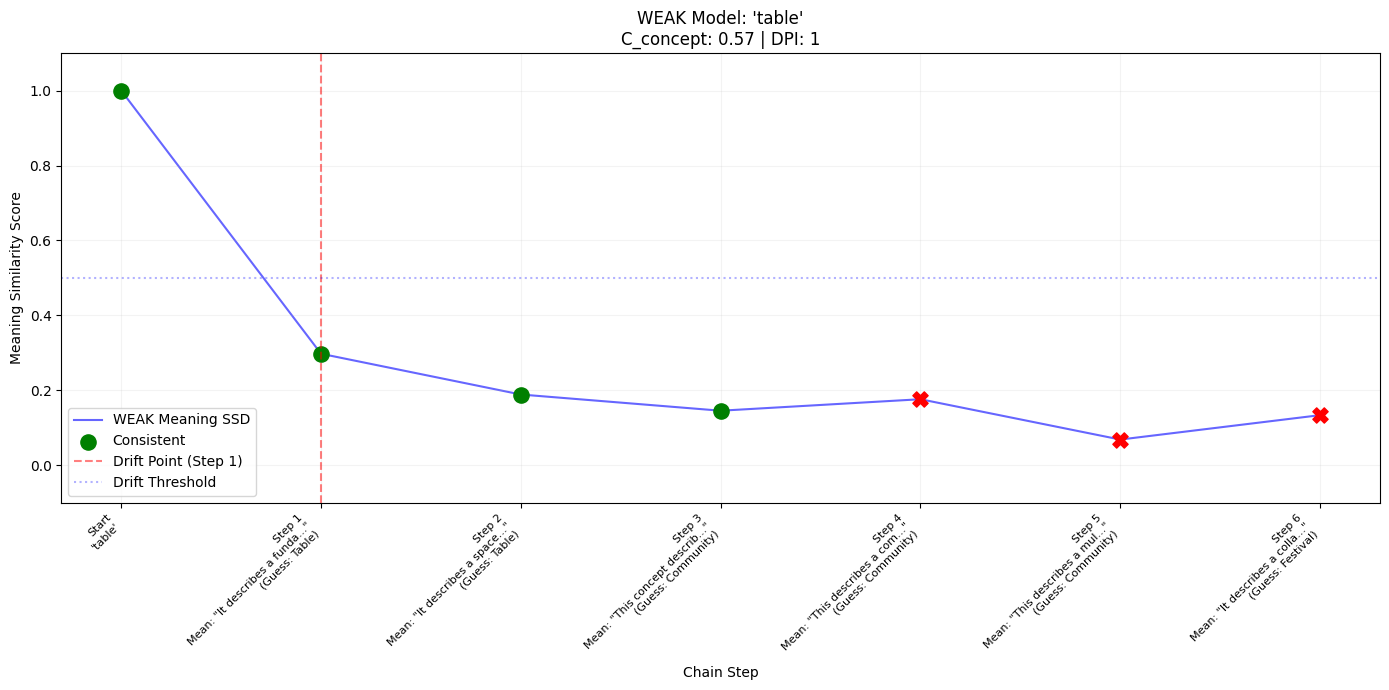


------------------------------------------------------------
STARTING GAME: 'table' | Model: [STRONG]
------------------------------------------------------------
Step 0 (Initial Input): "A long, flat surface mounted on sturdy legs offers a convenient place to set objects, dine, or work. Frequently found in homes, offices, and public venues, it provides a stable area for a wide range of activities. Its designs vary from modest wooden pieces to elegant dining spreads, sometimes incorporating drawers or storage for added practicality."

[Step 1]
  1. Interpreted Meaning: "A table—a flat surface on sturdy legs that provides a place to set things, eat, or work."
  2. Isolated Guess:      [table]
  3. Generated Desc:      "This piece of furniture offers a level area supported by sturdy legs, ideal for placing objects, enjoying meals, or carrying out tasks. Its design encourages organization and convenience in everyday settings."

[Step 2]
  1. Interpreted Meaning: "A table – a flat, leg‑su

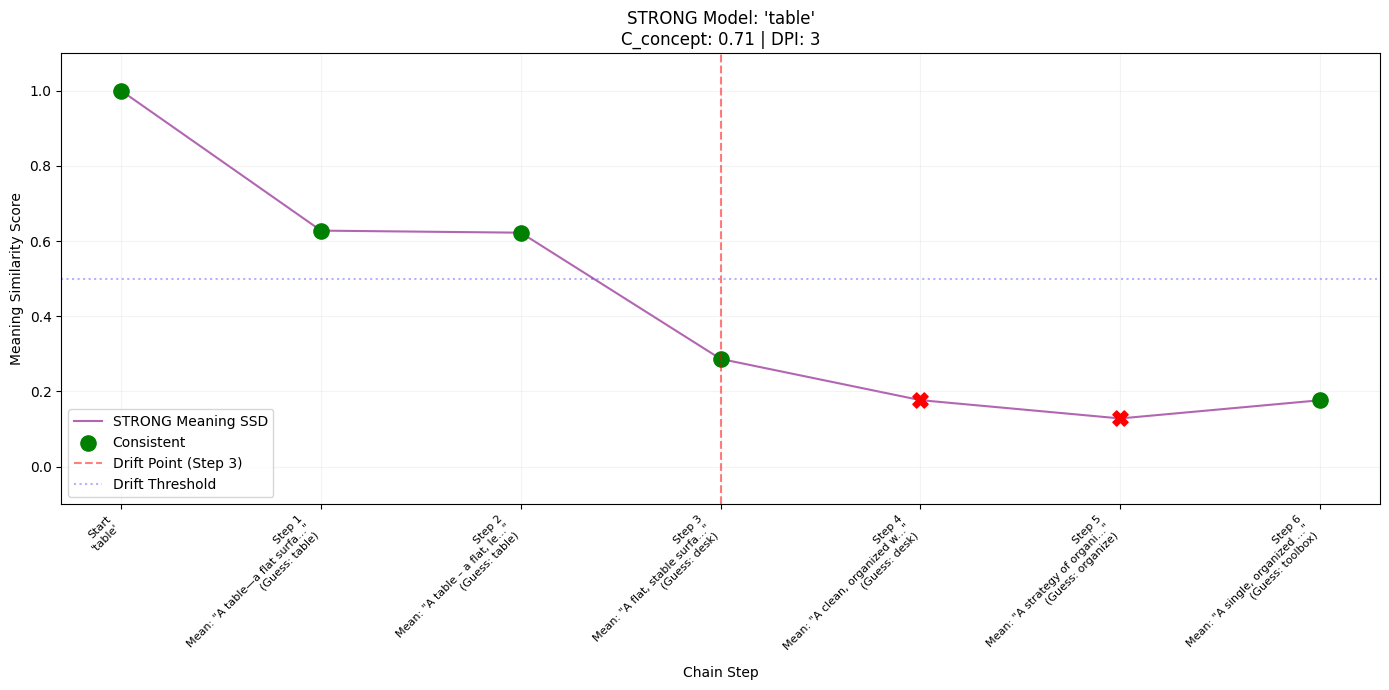


Generating Comparison Graph for: table...


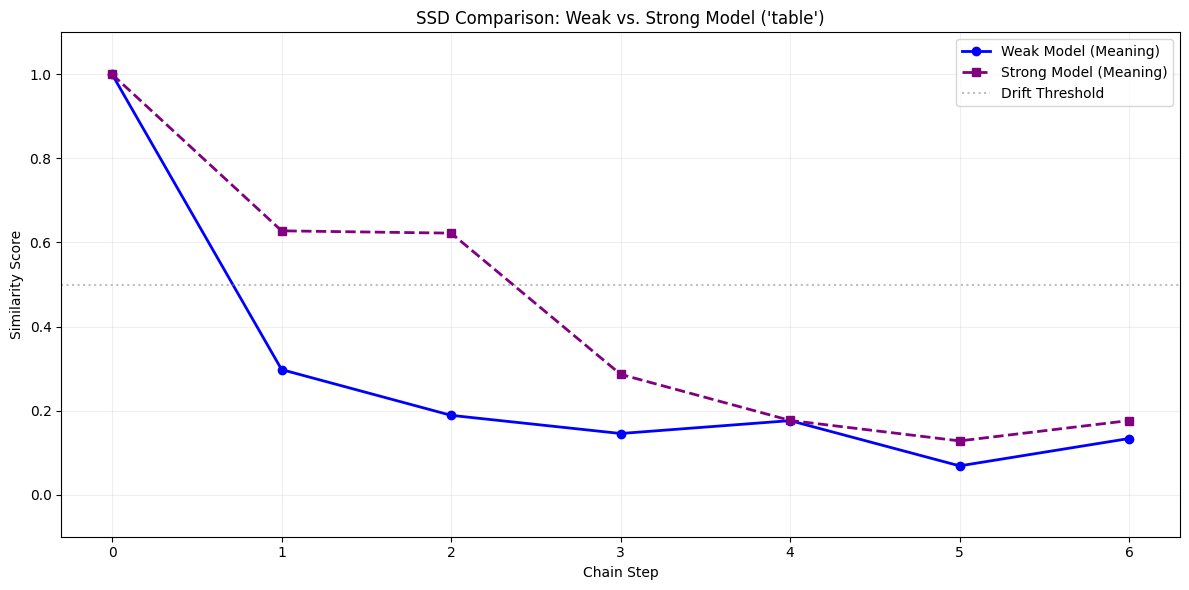


PROCESSING WORD: love

------------------------------------------------------------
STARTING GAME: 'love' | Model: [WEAK]
------------------------------------------------------------
Step 0 (Initial Input): "This profound and universal human experience is characterized by a deep emotional connection and affection towards another person, often accompanied by a strong desire for their well-being and happiness. It can manifest in various forms, such as romantic love, familial love, or platonic love, and is often marked by selflessness, vulnerability, and a willingness to prioritize the other person's needs. This complex and multifaceted emotion can bring immense joy, comfort, and meaning to our lives, while also potentially causing great pain and heartache."

[Step 1]
  1. Interpreted Meaning: "This description captures the essence of love as a fundamental and transformative human emotion, characterized by a selfless and vulnerable connection with another person that can bring great joy 

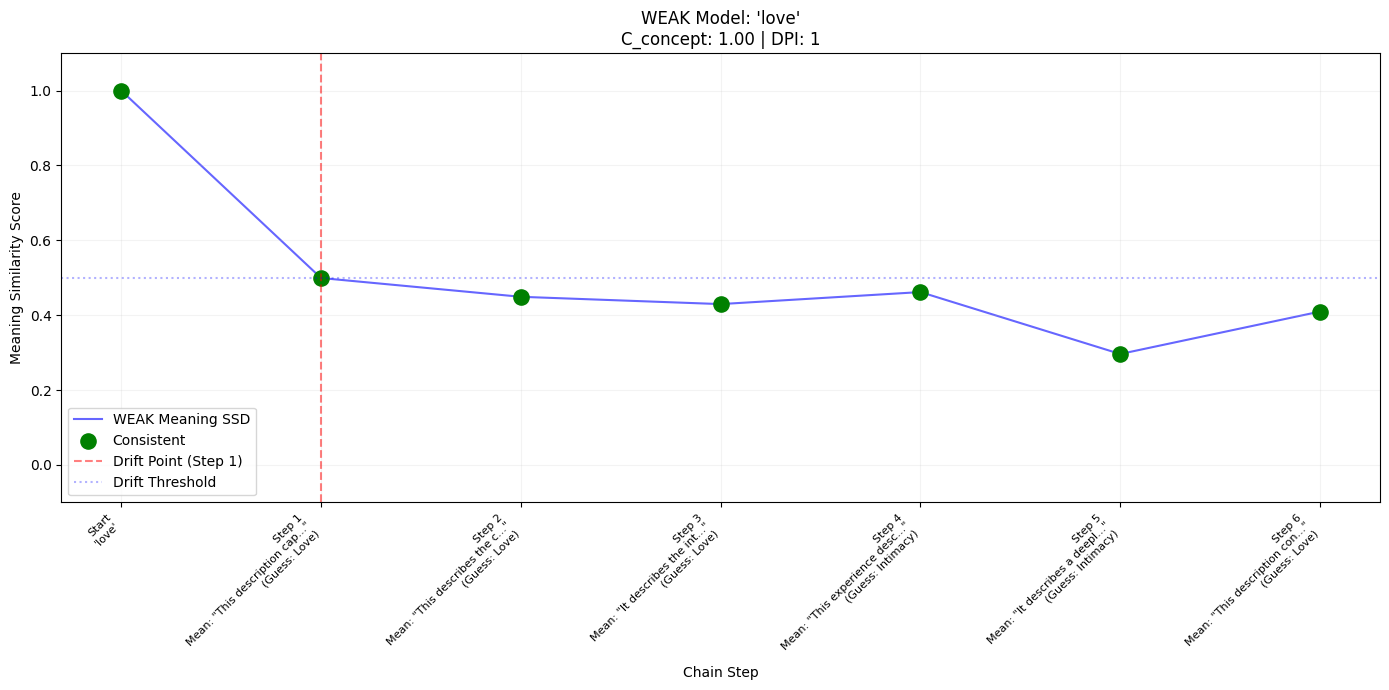


------------------------------------------------------------
STARTING GAME: 'love' | Model: [STRONG]
------------------------------------------------------------
Step 0 (Initial Input): "It is an intense bond that draws people together, fostering trust and mutual care. It manifests as deep affection, empathy, and a desire to support one another’s well‑being. This feeling often motivates selfless acts and a shared sense of belonging."

[Step 1]
  1. Interpreted Meaning: "A powerful, trust‑based bond that fuels deep empathy, self‑less support, and a shared sense of belonging."
  2. Isolated Guess:      [love]
  3. Generated Desc:      "When two people truly trust one another, an unseen thread of empathy and self‑less support is woven, turning every shared moment into a sanctuary of understanding. This bond transforms ordinary interactions into a collective sense of belonging, where each feels seen, supported, and deeply connected."

[Step 2]
  1. Interpreted Meaning: "It describes the d

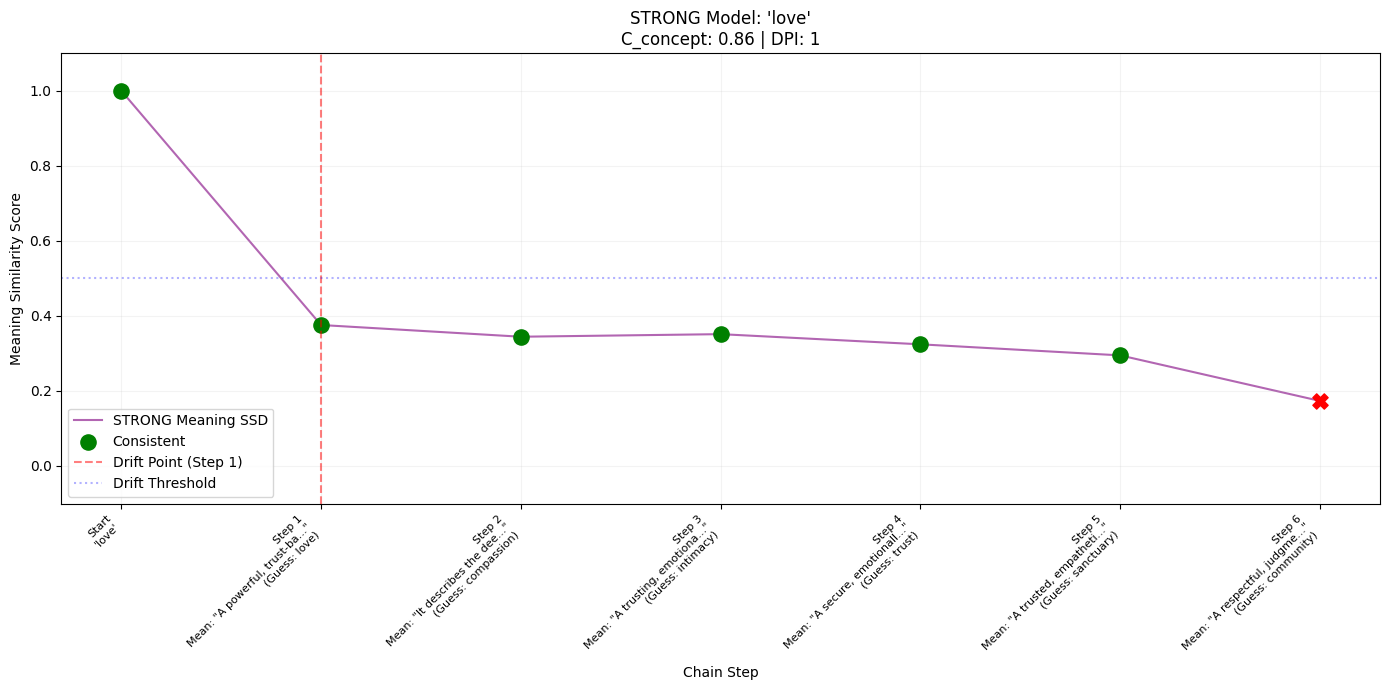


Generating Comparison Graph for: love...


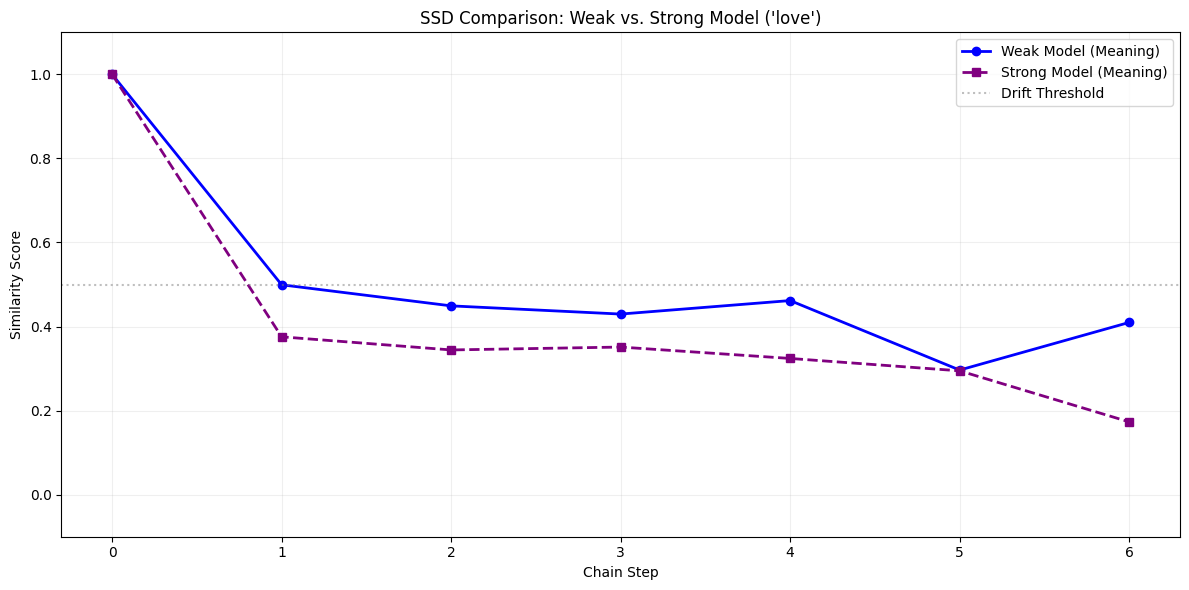


PROCESSING WORD: thimble

------------------------------------------------------------
STARTING GAME: 'thimble' | Model: [WEAK]
------------------------------------------------------------
Step 0 (Initial Input): "This small, hollow device is used to protect the finger from sharp needles and stitches when working with fabric, thread, and other materials. It is typically made of metal, plastic, or ceramic and is designed to fit snugly around the finger. This tool is an essential accessory for many craftspeople, including seamstresses, quilters, and embroiderers, as it helps to prevent injuries and make the work process easier and more precise."

[Step 1]
  1. Interpreted Meaning: "It describes a finger guard or protective device used in needlework and crafts to prevent injury from sharp objects."
  2. Isolated Guess:      [Thimble]
  3. Generated Desc:      "It's a small, protective device used by crafters to shield their fingers from accidental pricks or cuts when working with sharp n

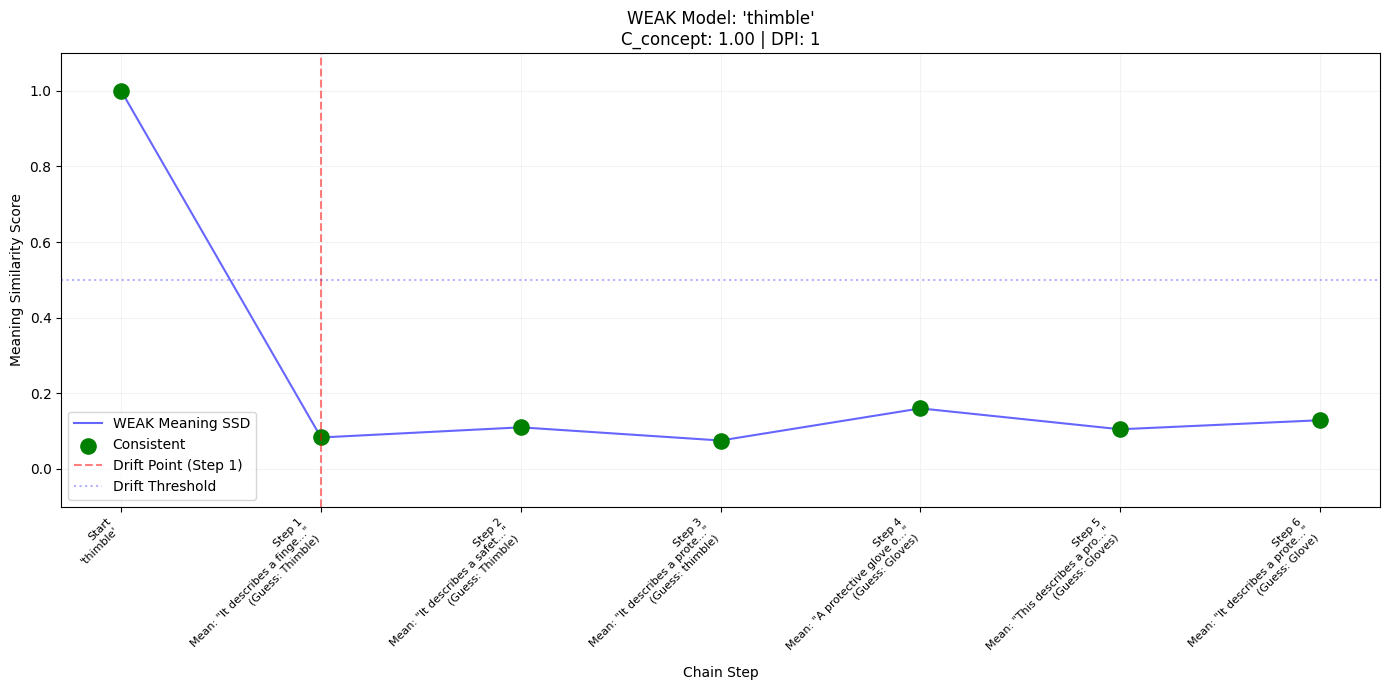


------------------------------------------------------------
STARTING GAME: 'thimble' | Model: [STRONG]
------------------------------------------------------------
Step 0 (Initial Input): "This small, cylindrical device is worn over the fingertip to shield it from the sharp point of a sewing needle. It features a short, rounded stem that fits snugly onto the needle, allowing the user to push the needle through fabric without direct contact. Often made of metal or durable plastic, it provides a firm, protective barrier that reduces the risk of cuts and improves the speed and precision of hand stitching."

[Step 1]
  1. Interpreted Meaning: "A finger‑mounted protective sleeve that covers a sewing needle so you can push it through fabric without risking a cut."
  2. Isolated Guess:      [needleguard]
  3. Generated Desc:      "A small, flexible cuff fits snugly over the fingertip, concealing a sewing needle inside a secure enclosure. This lets you push the needle through fabric with con

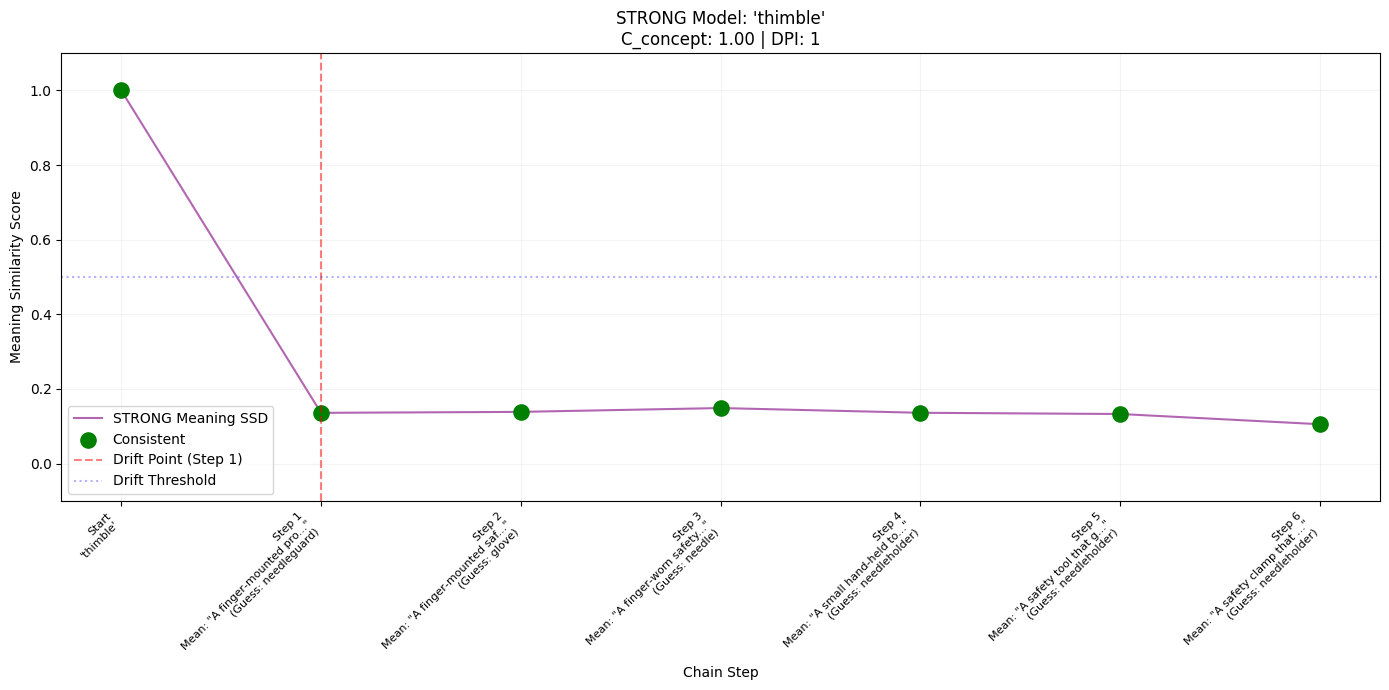


Generating Comparison Graph for: thimble...


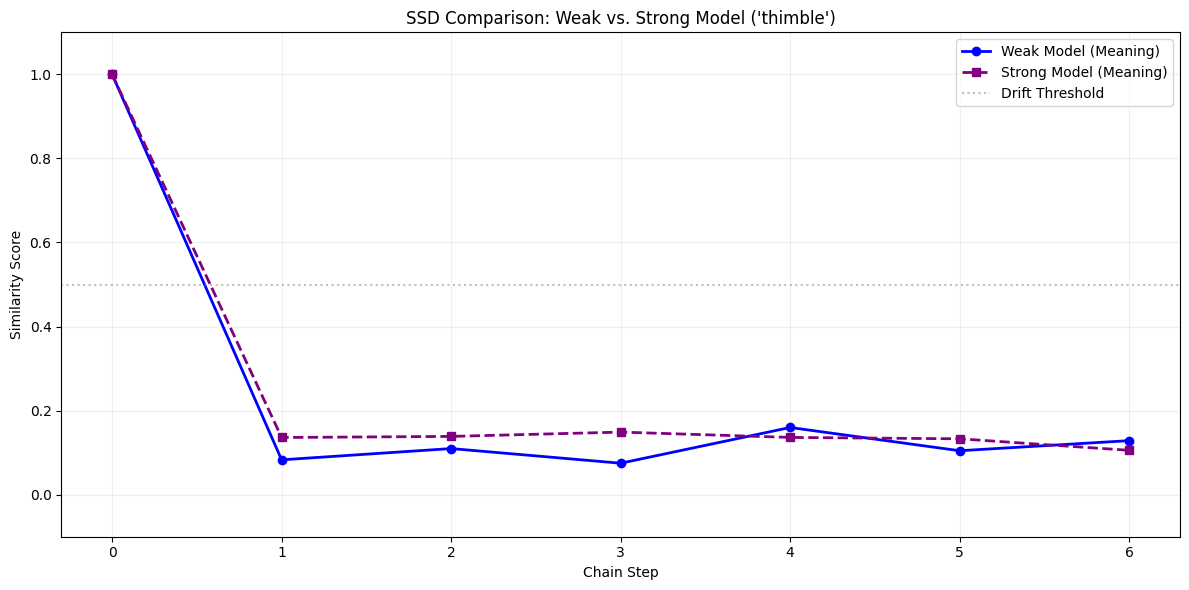


PROCESSING WORD: epistomology

------------------------------------------------------------
STARTING GAME: 'epistomology' | Model: [WEAK]
------------------------------------------------------------
Step 0 (Initial Input): "This branch of philosophy examines the nature, sources, and limits of knowledge, seeking to understand how we can be certain about what we know and how we acquire knowledge. It involves studying the relationship between the knower and the known, as well as the methods and principles used to determine what is true. By investigating the nature of knowledge, this field aims to provide a foundation for understanding the reliability and validity of knowledge claims."

[Step 1]
  1. Interpreted Meaning: "It describes Epistemology, the study of how we acquire and justify knowledge."
  2. Isolated Guess:      [Epistemology]
  3. Generated Desc:      "This field of study explores how we come to know things and what makes us certain that our knowledge is true, examining the 

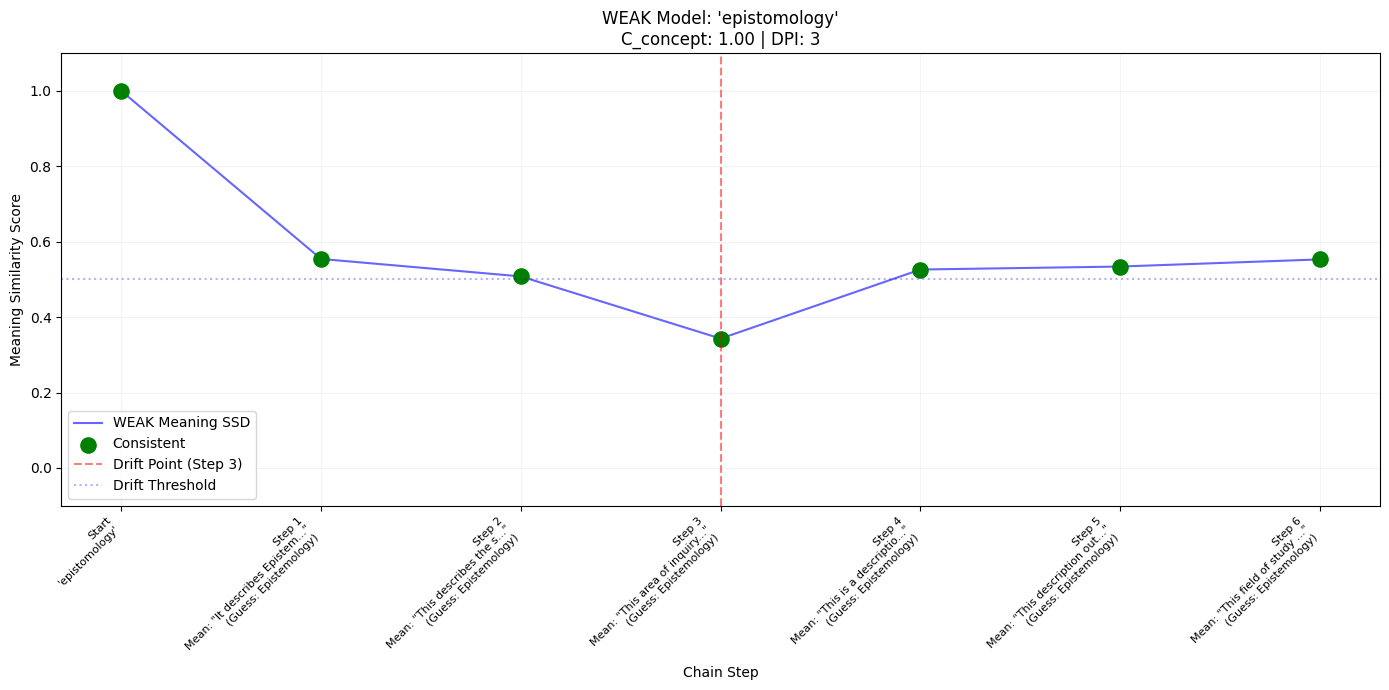


------------------------------------------------------------
STARTING GAME: 'epistomology' | Model: [STRONG]
------------------------------------------------------------
Step 0 (Initial Input): "It is the philosophical inquiry into how we come to know things, examining the nature, scope, and limits of human understanding. It scrutinizes the sources of knowledge—such as perception, reasoning, and testimony—and the criteria that make beliefs justified or true. By questioning what counts as evidence and how certainty can be achieved, it shapes our approach to learning, belief, and skepticism."

[Step 1]
  1. Interpreted Meaning: "It’s the systematic study of how we come to hold true beliefs—examining the sources, justification, and limits of our knowledge, which is what epistemology means."
  2. Isolated Guess:      [epistemology]
  3. Generated Desc:      "It is the systematic examination of how we acquire, justify, and validate our beliefs, exploring the sources, limits, and criteria o

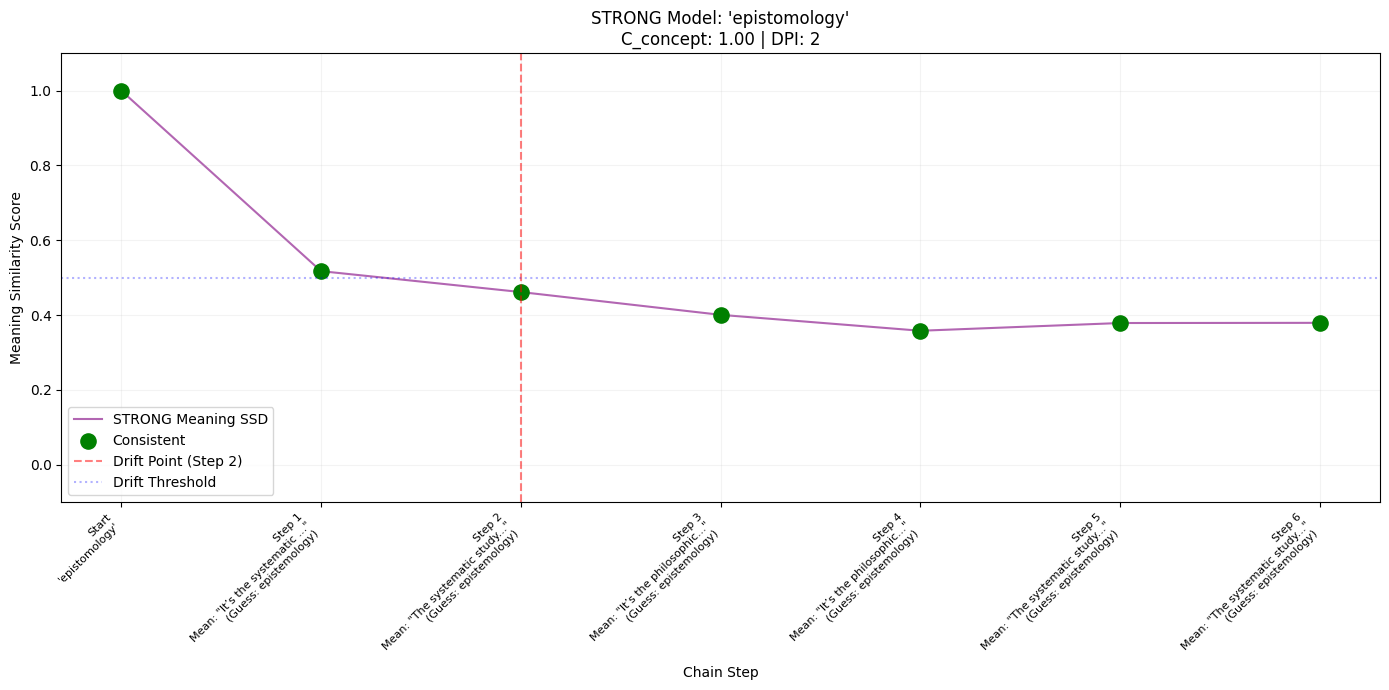


Generating Comparison Graph for: epistomology...


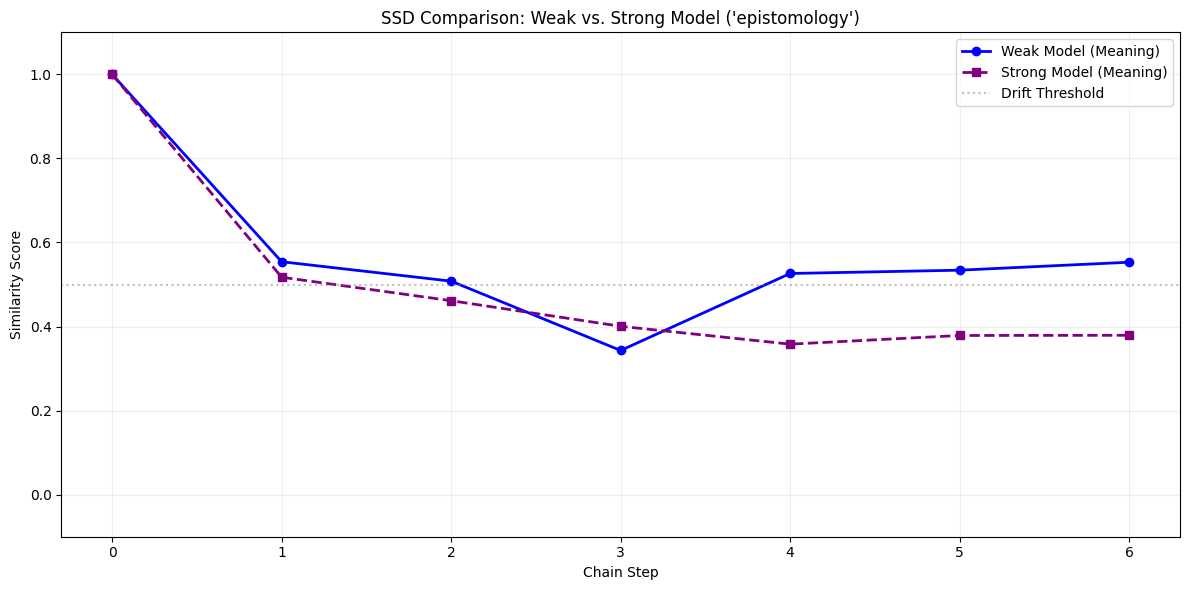


All results saved.


In [12]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from sentence_transformers import SentenceTransformer, util

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================

# REPLACE THIS with your actual Nebius API key
os.environ["NEBIUS_API_KEY"] = "v1.CmQKHHN0YXRpY2tleS1lMDBncDBhYThtOTF4bnI3YmYSIXNlcnZpY2VhY2NvdW50LWUwMHh0dnBxZTZ4Y3I0bnk3NjIMCMuYtckGENKzjvsBOgwIy5vNlAcQwMWB6AJAAloDZTAw.AAAAAAAAAAF3-m3KEb-kNhNMSEYKc-x1nUMrz8p95iA8DgKwWHvnDQNfNEaiJtvIjfXQtUvU6qaYci0Vk_stRmKvxwzTcfMI"

MODEL_CONFIG = {
    "weak":   "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "strong": "openai/gpt-oss-20b"
}

def build_model(model_name):
    return ChatOpenAI(
        base_url="https://api.studio.nebius.ai/v1",
        api_key=os.environ["NEBIUS_API_KEY"],
        model=model_name,
        temperature=0.7
    )

print("Loading models...")
models = {role: build_model(name) for role, name in MODEL_CONFIG.items()}
embedder = SentenceTransformer("all-MiniLM-L6-v2")
print("Models loaded.")

# ==========================================
# 2. CORE GAME LOGIC (Telephone)
# ==========================================

def one_chain_block(player_model, chain_meanings, chain_desc, chain_guesses):
    """
    A single turn played by ONE specific model.
    """
    previous_description = chain_desc[-1]

    # --- Action A: Formulate Meaning (Core Logic) ---
    # The model summarizes what it thinks the description is about.
    meaning_response = player_model.invoke([
        HumanMessage(
            f"You received this description: \"{previous_description}\".\n"
            f"In one short sentence or phrase, interpret what this describes. "
            f"Do NOT just guess a word, explain the *meaning* or *concept* you understood."
        )
    ])
    meaning = meaning_response.content.strip()
    chain_meanings.append(meaning)

    # --- Action B: Describe the Meaning (Main Logic) ---
    # The model creates the next description based on the MEANING it just formulated.
    description_response = player_model.invoke([
        HumanMessage(
            f"You interpret the concept as: \"{meaning}\".\n"
            f"Now, describe this concept for the next person in ONLY 2 sentences."
            f"Do NOT name the concept directly."
        )
    ])
    new_description = description_response.content.strip()
    chain_desc.append(new_description)

    # --- Action C: Explicit Guess (Side Task) ---
    # An isolated guess just for logging/tracking purposes.
    guess_response = player_model.invoke([
        HumanMessage(
            f"You received this description: \"{previous_description}\".\n"
            f"If you had to guess the specific single word being described, what would it be? "
            f"Reply with ONLY the word, no punctuation."
        )
    ])
    guess = guess_response.content.strip().strip(".\"")
    chain_guesses.append(guess)

    return chain_meanings, chain_desc, chain_guesses

def run_full_game(word, model_key, steps=6):
    """
    Runs the entire telephone game using ONE specific model (Weak OR Strong).
    Prints details at every step.
    """
    chain_meanings = [word]
    chain_desc = []
    chain_guesses = []

    active_model = models[model_key]

    # --- Initial Setup ---
    print(f"\n{'-'*60}")
    print(f"STARTING GAME: '{word}' | Model: [{model_key.upper()}]")
    print(f"{'-'*60}")

    # Initial description
    initial_desc = active_model.invoke([
        HumanMessage(f"Describe the concept of '{word}' in 3 sentences without naming it.")
    ]).content
    chain_desc.append(initial_desc)

    print(f"Step 0 (Initial Input): \"{initial_desc}\"")

    # --- The Game Loop ---
    for i in range(steps):
        chain_meanings, chain_desc, chain_guesses = one_chain_block(
            active_model, chain_meanings, chain_desc, chain_guesses
        )

        # --- PRINTING STEP DETAILS ---
        print(f"\n[Step {i+1}]")
        print(f"  1. Interpreted Meaning: \"{chain_meanings[-1]}\"")
        print(f"  2. Isolated Guess:      [{chain_guesses[-1]}]")
        print(f"  3. Generated Desc:      \"{chain_desc[-1]}\"")

    return chain_meanings, chain_desc, chain_guesses

# ==========================================
# 3. METRICS
# ==========================================

def calculate_ssd(original_word, chain_meanings):
    """Calculates Semantic Similarity Decay (Meaning vs Original)."""
    orig_emb = embedder.encode(original_word, convert_to_tensor=True)
    sims = []
    for meaning_text in chain_meanings:
        meaning_emb = embedder.encode(meaning_text, convert_to_tensor=True)
        sim = util.cos_sim(orig_emb, meaning_emb).item()
        sims.append(sim)
    return sims

def calculate_dpi(ssd_values, threshold=0.5):
    """Drift Point Index."""
    for t, score in enumerate(ssd_values):
        if score < threshold:
            return t
    return None

def calculate_conceptual_consistency(judge_model, original_word, chain_meanings):
    """LLM Judge for Category Consistency."""
    cat_prompt = f"What is the single broad category for '{original_word}'? (e.g., Nature, Object, Animal, Emotion). Reply with ONE word."
    category = judge_model.invoke([HumanMessage(cat_prompt)]).content.strip()

    consistency_mask = []
    for meaning in chain_meanings:
        check_prompt = (
            f"The original category is '{category}'.\n"
            f"Does the following description/meaning fall into this category?\n"
            f"Meaning: \"{meaning}\"\n"
            f"Reply 'YES' if it is semantically close or the same category, 'NO' if it is completely different."
        )
        response = judge_model.invoke([HumanMessage(check_prompt)]).content.strip().upper()
        consistency_mask.append(1 if "YES" in response else 0)

    c_concept = sum(consistency_mask) / len(consistency_mask)
    return consistency_mask, c_concept, category

# ==========================================
# 4. VISUALIZATION
# ==========================================

def plot_model_performance(word, model_name, chain_meanings, chain_guesses, color_code):
    """Plots performance graph for a single model."""
    # Metrics
    w_ssd = calculate_ssd(word, chain_meanings)
    dpi = calculate_dpi(w_ssd, threshold=0.5)

    # Judge is always Strong model
    const_mask, c_concept, cat_name = calculate_conceptual_consistency(models['strong'], word, chain_meanings)

    # Plot
    steps = np.arange(len(w_ssd))
    plt.figure(figsize=(14, 7))

    plt.plot(steps, w_ssd, linestyle='-', color=color_code, alpha=0.6, label=f'{model_name} Meaning SSD', zorder=1)

    for i, (score, is_const) in enumerate(zip(w_ssd, const_mask)):
        color = 'green' if is_const else 'red'
        marker = 'o' if is_const else 'X'
        label = "Consistent" if (is_const and i==0) else ("Inconsistent" if (not is_const and i==0) else "")
        plt.scatter(i, score, color=color, s=120, marker=marker, zorder=2, label=label)

    if dpi is not None:
        plt.axvline(x=dpi, color='red', linestyle='--', alpha=0.5, label=f'Drift Point (Step {dpi})')

    plt.axhline(0.5, color='blue', linestyle=':', alpha=0.3, label='Drift Threshold')

    plt.title(f"{model_name} Model: '{word}'\nC_concept: {c_concept:.2f} | DPI: {dpi}")
    plt.xlabel("Chain Step")
    plt.ylabel("Meaning Similarity Score")
    plt.ylim(-0.1, 1.1)

    # Label with Meaning + Guess
    x_labels = []
    for i in range(len(chain_meanings)):
        if i == 0:
            x_labels.append(f"Start\n'{word}'")
        else:
            guess_str = chain_guesses[i-1] if (i-1) < len(chain_guesses) else "?"
            meaning_str = (chain_meanings[i][:20] + '...') if len(chain_meanings[i]) > 20 else chain_meanings[i]
            x_labels.append(f"Step {i}\nMean: \"{meaning_str}\"\n(Guess: {guess_str})")

    plt.xticks(steps, x_labels, rotation=45, ha='right', fontsize=8)
    plt.grid(True, alpha=0.15)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

    return w_ssd

def plot_direct_comparison(word, weak_ssd, strong_ssd):
    """Plots Weak SSD vs Strong SSD comparison."""
    max_len = max(len(weak_ssd), len(strong_ssd))
    steps = np.arange(max_len)

    # Padding if necessary
    weak_ssd += [None] * (max_len - len(weak_ssd))
    strong_ssd += [None] * (max_len - len(strong_ssd))

    plt.figure(figsize=(12, 6))
    plt.plot(steps, weak_ssd, linestyle='-', color='blue', linewidth=2, label='Weak Model (Meaning)', marker='o')
    plt.plot(steps, strong_ssd, linestyle='--', color='purple', linewidth=2, label='Strong Model (Meaning)', marker='s')
    plt.axhline(0.5, color='gray', linestyle=':', alpha=0.5, label='Drift Threshold')

    plt.title(f"SSD Comparison: Weak vs. Strong Model ('{word}')")
    plt.xlabel("Chain Step")
    plt.ylabel("Similarity Score")
    plt.ylim(-0.1, 1.1)
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# ==========================================
# 5. MAIN EXECUTION LOOP
# ==========================================

if __name__ == "__main__":
    test_words = ['table','love','thimble','epistomology']

    all_results = []

    for word in test_words:
        print(f"\n{'='*40}")
        print(f"PROCESSING WORD: {word}")
        print(f"{'='*40}")

        # 1. Experiment A: WEAK Model
        weak_meanings, weak_desc, weak_guesses = run_full_game(word, "weak", steps=6)
        weak_ssd = plot_model_performance(word, "WEAK", weak_meanings, weak_guesses, color_code="blue")

        # 2. Experiment B: STRONG Model
        strong_meanings, strong_desc, strong_guesses = run_full_game(word, "strong", steps=6)
        strong_ssd = plot_model_performance(word, "STRONG", strong_meanings, strong_guesses, color_code="purple")

        # 3. Comparison Graph
        print(f"\nGenerating Comparison Graph for: {word}...")
        plot_direct_comparison(word, weak_ssd, strong_ssd)

        # Save Data
        all_results.append({
            "word": word,
            "weak_data": {
                "meanings": weak_meanings,
                "guesses": weak_guesses,
                "ssd": weak_ssd,
                "final_desc": weak_desc[-1]
            },
            "strong_data": {
                "meanings": strong_meanings,
                "guesses": strong_guesses,
                "ssd": strong_ssd,
                "final_desc": strong_desc[-1]
            }
        })

    # 4. Save Results to File
    with open("experiment_final_comparison.json", "w") as f:
        json.dump(all_results, f, indent=4)
    print("\nAll results saved.")